## Used packages

In [32]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
import warnings
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers,
    SequentialEvaluator,
)
from dike_model_function import DikeNetwork 
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench.em_framework.parameters import Constant

warnings.filterwarnings("ignore")

## Creating samples LHC 

In [33]:
# Create an instance of the model which is usable with the EMA workbench
dike_model, planning_steps = get_model_for_problem_formulation(6)

In [34]:
zero_policy = {"DaysToThreat": 0}
zero_policy.update({f"DikeIncrease {n}": 0 for n in planning_steps})
zero_policy.update({f"RfR {n}": 0 for n in planning_steps})

pol0 = {}

for key in dike_model.levers:
    s1, s2 = key.name.split("_")
    pol0.update({key.name: zero_policy[s2]})

policy0 = Policy("Policy 0", **pol0)

In [35]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=10,policies=10,uncertainty_sampling=Samplers.LHS)
#n_processes=-1
experiments, outcomes = results


100%|████████████████████████████████████████| 100/100 [00:15<00:00,  6.65it/s]


## Preprocess data samples LHC 

In [36]:
experiments_unc =experiments.iloc[:,0:19]
df = pd.DataFrame(outcomes) 

In [37]:
# df["Expected Annual Damage"] = df["A.1_Expected Annual Damage"] + df["A.2_Expected Annual Damage"] + df["A.3_Expected Annual Damage"] + df["A.4_Expected Annual Damage"] + df["A.5_Expected Annual Damage"]
# df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df["A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]

In [38]:
# df_feature_importance_out = df[["Expected Evacuation Costs","Expected Annual Damage", "Expected Number of Deaths","A.5_Expected Number of Deaths","A.5_Expected Annual Damage","Expected Evacuation Costs"]]

## Feature importance

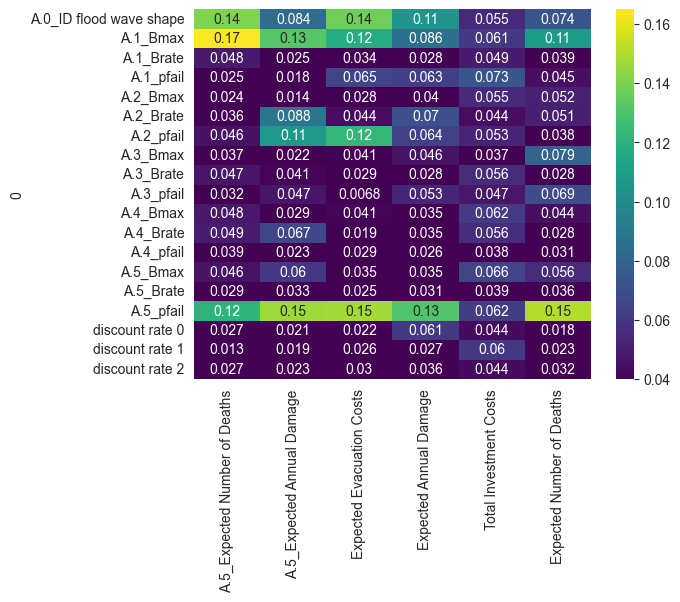

In [39]:
x = experiments_unc
y = df

fs = feature_scoring.get_feature_scores_all(x, y,)
sns.heatmap(fs, cmap="viridis", annot=True,vmin=0.04)
plt.show()

In [40]:
from ema_workbench.analysis import RuleInductionType


y = (
    (df["A.5_Expected Number of Deaths"] > list(np.sort(df["A.5_Expected Number of Deaths"]))[np.int64(0.80* len(df["A.5_Expected Number of Deaths"]))])
    |
    (df['A.5_Expected Annual Damage'] > list(np.sort(df['A.5_Expected Annual Damage']))[np.int64(0.8* len(df['A.5_Expected Annual Damage']))])
     )

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)

,1
0,
A.5_pfail,0.201591
A.0_ID flood wave shape,0.133543
A.1_Bmax,0.119316
A.2_pfail,0.115032
A.2_Brate,0.084954
A.4_Brate,0.060449
A.1_Brate,0.037958
A.3_Brate,0.033789
discount rate 0,0.028067


In [41]:
from ema_workbench.analysis import RuleInductionType


y = (
    (df['Expected Number of Deaths'] > list(np.sort(df["Expected Number of Deaths"]))[int(0.8* len(df['Expected Number of Deaths']))])
    |(df['Expected Annual Damage'] > list(np.sort(df["Expected Annual Damage"]))[int(0.8* len(df['Expected Annual Damage']))])
     )

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)

,1
0,
A.5_pfail,0.134532
A.1_pfail,0.087969
A.0_ID flood wave shape,0.072622
A.2_pfail,0.070608
A.3_pfail,0.067876
A.5_Bmax,0.056209
A.1_Bmax,0.053533
discount rate 2,0.050815
discount rate 1,0.048088


In [42]:
from ema_workbench.analysis import RuleInductionType


y = (
    (df["Expected Evacuation Costs"] > list(np.sort(df["Expected Evacuation Costs"]))[np.int64(0.80* len(df["Expected Evacuation Costs"]))])
     )

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)

,1
0,
A.5_pfail,0.146179
A.5_Brate,0.075631
A.0_ID flood wave shape,0.074697
A.2_Brate,0.070996
A.1_Bmax,0.066476
A.4_pfail,0.065860
A.2_pfail,0.065306
discount rate 2,0.056913
A.1_pfail,0.048949


## Filter important uncertainties and create samples SOBOL 

In [43]:
dike_model_1, planning_steps = get_model_for_problem_formulation(6)

In [44]:
dele = []
for x in dike_model_1.uncertainties:
    if x.name not in ["A.1_pfail","A.2_pfail","A.3_pfail","A.4_pfail","A.5_pfail", "A.0_ID flood wave shape"]:
        dele.append(x.name)
for i in dele:
    dike_model_1.uncertainties.__delitem__(i)


dike_model_1.constants.extend(Constant("discount rate 0",2.5))
dike_model_1.constants.extend(Constant("discount rate 1",2.5))
dike_model_1.constants.extend(Constant("discount rate 2",2.5))

# dike_model_1.constants.extend(Constant('A.0_ID flood wave shape',17))

dike_model_1.constants.extend(Constant('A.1_Bmax',190))
dike_model_1.constants.extend(Constant('A.1_Brate',1.5))

dike_model_1.constants.extend(Constant('A.2_Bmax',190))
dike_model_1.constants.extend(Constant('A.2_Brate',1.5))

dike_model_1.constants.extend(Constant('A.3_Bmax',190))
dike_model_1.constants.extend(Constant('A.3_Brate',1.5))

dike_model_1.constants.extend(Constant('A.4_Bmax',190))
dike_model_1.constants.extend(Constant('A.4_Brate',1.5))

dike_model_1.constants.extend(Constant('A.5_Bmax',190))
dike_model_1.constants.extend(Constant('A.5_Brate',1.5))


In [45]:
with MultiprocessingEvaluator(dike_model_1) as evaluator:
    results = evaluator.perform_experiments(scenarios=1,policies=1,uncertainty_sampling=Samplers.SOBOL)
n_processes=-1
experiments, outcomes = results


100%|██████████████████████████████████████████| 14/14 [00:01<00:00,  8.31it/s]


## Preprocess data samples SOBOL

In [46]:
experiments_unc =experiments.iloc[:,0:5]

In [47]:
df =pd.DataFrame(outcomes)

In [48]:
# df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df[
#     "A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]
# df["Expected Annual Damage"] = df["A.1_Expected Annual Damage"] + df["A.2_Expected Annual Damage"] + df["A.3_Expected Annual Damage"] + df["A.4_Expected Annual Damage"] + df["A.5_Expected Annual Damage"]
# 
# outcomes["Expected Number of Deaths"] = df["Expected Number of Deaths"]
# outcomes["Expected Annual Damage"] = df["Expected Annual Damage"]

## Feature importance (not required but nice to know)

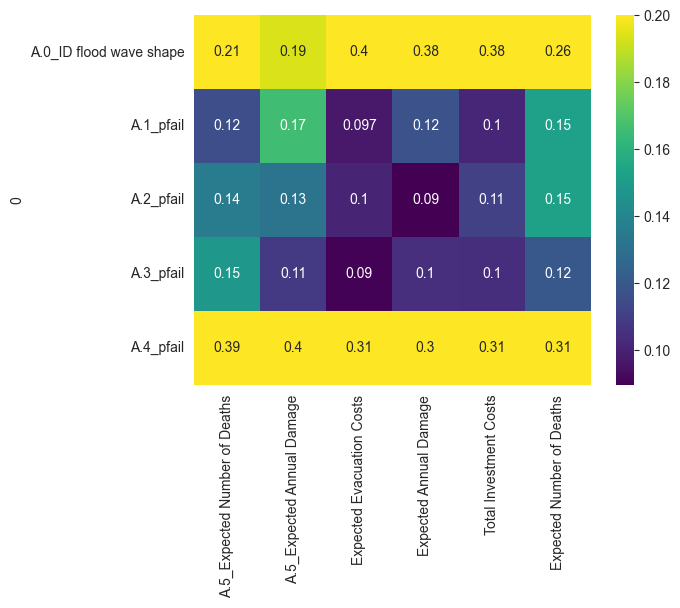

In [49]:


x = experiments_unc
y = df

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True, vmax=0.2)
plt.show()

In [50]:
df_feature_importance_out.to_csv('data\OpenScenRes.csv')

## SOBOL analysis 

In [51]:
problem = get_SALib_problem(dike_model_1.uncertainties)

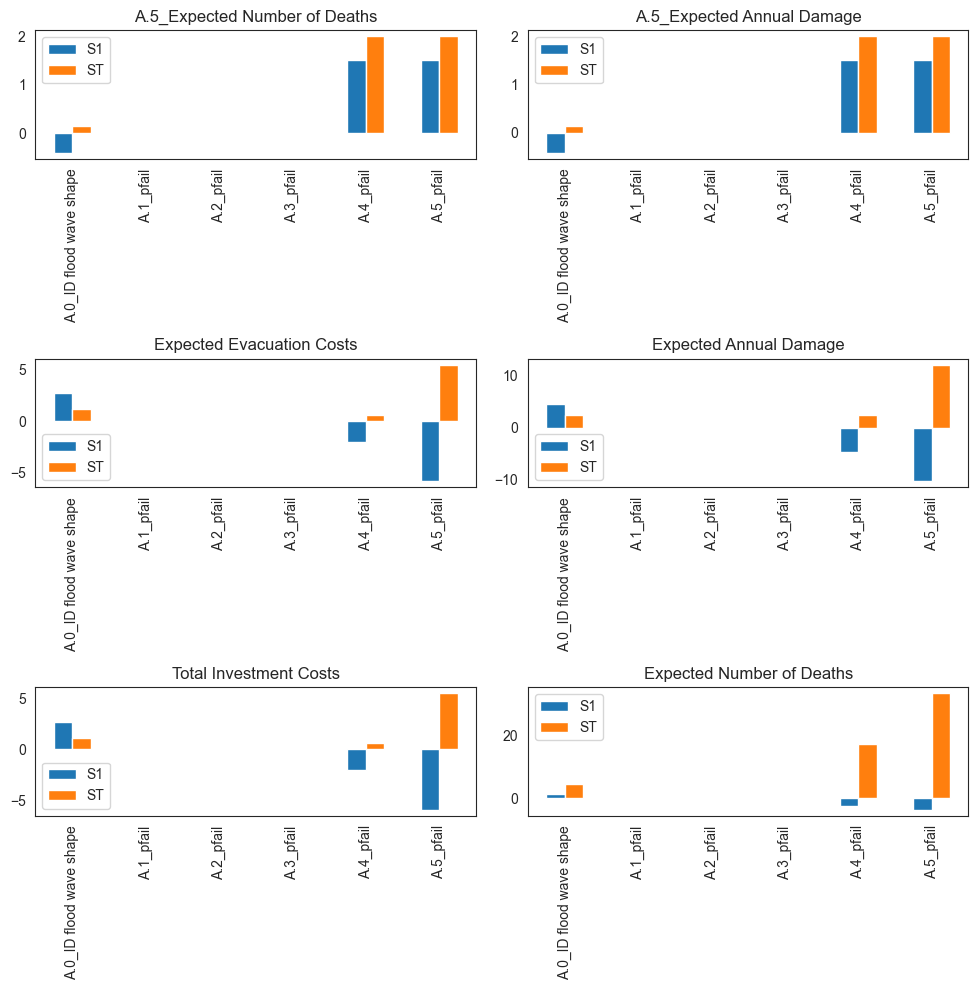

In [52]:
sns.set_style('white')
fig, ax = plt.subplots(3,2,figsize=(10,10))
ax = ax.flatten()

for index,kpi in enumerate(df.columns):
    Si = sobol.analyze(problem,np.array(outcomes[kpi]), calc_second_order=True, print_to_console=False)
    Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])
    
    
    
    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]
    ax[index].title.set_text(kpi) 
    indices.plot.bar(yerr=err.values.T,ax=ax[index])
    # fig.set_size_inches(8,6)
    # fig.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()